In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

**What is a Gated Recurrent Unit (GRU)?**
- A `Gated Recurrent Unit` `(GRU)` is a type of Recurrent Neural Network (RNN) that solves the vanishing gradient problem. It's a simpler and more computationally efficient alternative to the Long Short-Term Memory (LSTM) network. The GRU achieves this by using only two gates: the reset gate and the update gate.

- Reset Gate (r_t): Controls how much of the previous hidden state should be forgotten.

- Update Gate (z_t): Determines how much of the previous hidden state should be carried over to the current hidden state.

- A Simple GRU Example: Time Series Prediction:

This example will demonstrate how a GRU can be used for a simple time series prediction task.

In [2]:
# Generate synthetic time series data
import numpy as np
def generate_time_series_data(num_samples, seq_length):
    import numpy as np
    x = np.linspace(0, 10, num_samples)
    y = np.sin(x) + np.random.normal(0, 0.1, num_samples)

    X, Y = [], []
    for i in range(len(y) - seq_length):
        X.append(y[i:i + seq_length])
        Y.append(y[i + seq_length])

    return np.array(X), np.array(Y)

# Parameters
seq_length = 10
num_samples = 200

# Prepare data
X_raw, Y_raw = generate_time_series_data(num_samples, seq_length)
X_reshaped = X_raw.reshape(X_raw.shape[0], X_raw.shape[1], 1)

# Split data
train_size = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:train_size], X_reshaped[train_size:]
Y_train, Y_test = Y_raw[:train_size], Y_raw[train_size:]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (152, 10, 1)
Testing data shape: (38, 10, 1)


In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Traning Setup: Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=3, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1
)

## GRU (Gated Recurrent Unit) Cell Architecture

![GRU Cell Architecture](/content/drive/MyDrive/PrognosAI_OCT25/Notebooks/TheArchitecture-of-the-gated-recurrent-unit-GRU-cell.png)

The GRU cell is a simplified variant of the LSTM cell, designed to address vanishing gradient problems and improve sequence modeling efficiency.

### Main Components

- **Reset gate (\( r_t \))**: Decides how much of the past hidden state (\( h_{t-1} \)) to forget before combining with the current input (\( x_t \)).
- **Update gate (\( z_t \))**: Controls the extent to which the previous hidden state is carried forward to the next time step.
- **Candidate hidden state (\( \hat{h}_t \))**: Generated from the current input and reset-modified hidden state, using the tanh activation function.
- **Final hidden state (\( h_t \))**: A blend of the previous hidden state and the candidate, controlled by the update gate.

### GRU Equations

\[
\begin{align*}
r_t &= \sigma(W_r [h_{t-1}, x_t]) \\
z_t &= \sigma(W_z [h_{t-1}, x_t]) \\
\hat{h}_t &= \tanh(W [r_t * h_{t-1}, x_t]) \\
h_t &= (1 - z_t) * h_{t-1} + z_t * \hat{h}_t
\end{align*}
\]

Where:
- $\sigma$ is the sigmoid activation function,
- $ [h_{t-1}, x_t] $ denotes concatenation of previous hidden state and current input.

The GRU cell’s gating mechanism allows it to retain useful information for long sequences and update its hidden state effectively.


### Build & Train the model

In [4]:
# Build the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=False, input_shape=(seq_length, 1)))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display model summary
model.summary()

# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.1,  callbacks=[early_stopping, reduce_lr, model_ckpt],verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.6159
Epoch 1: saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 0.5712 - val_loss: 0.7017 - learning_rate: 0.0010
Epoch 2/20
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4665
Epoch 2: saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4325 - val_loss: 0.4209 - learning_rate: 0.0010
Epoch 3/20
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3531
Epoch 3: saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2922 - val_loss: 0.2109 - learning_rate: 0.0010
Epoch 4/20
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1656
Epoch 4: saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1593 - val_loss: 0.0810 - learning_rate: 0.0010
Epoch 5/20
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0880
Epoch 5: saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0779 - val_loss: 0.0186 - learning_rate

### Visualize the Result

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


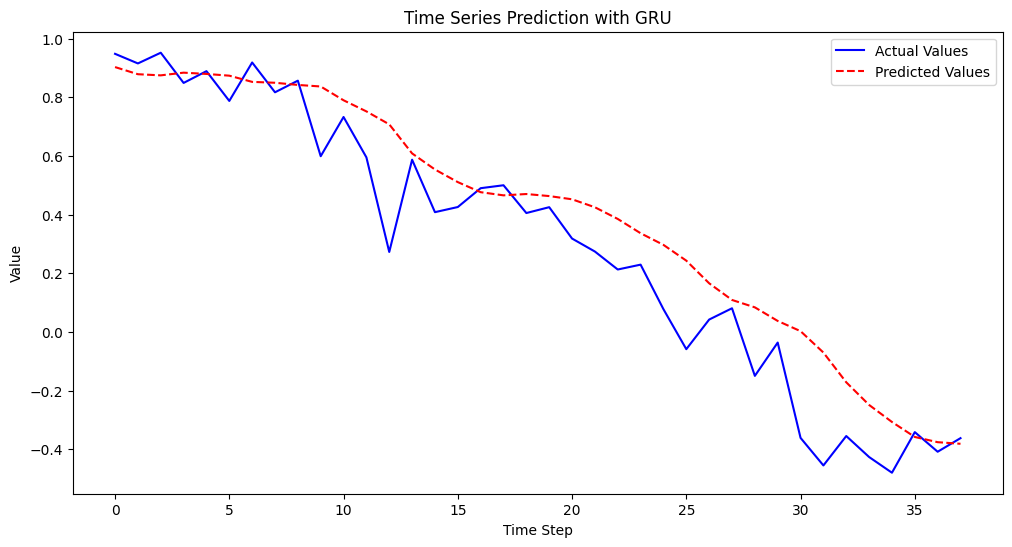

In [5]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(Y_test, label='Actual Values', color='blue')
plt.plot(predictions, label='Predicted Values', color='red', linestyle='dashed')
plt.title('Time Series Prediction with GRU')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

Observations

The model slightly shows underfitting.
the epochs stopped early because there is no significant improvement in the validation loss.
The graph shows that the predicted values are not very close to the actual values.
The improvement between epochs 11-13 improvement slow down so the learning rate is changed.
